# **Short Brief**

Pembuatan ML ini merupakan langkah lanjutan dalam pengerjaan proyek **Delivery Performance Analysis and Delivery Time Prediction Based on Olist Dataset**, berdasarkan hasil Data Cleaning & Preprocessing, dan EDA sebelumnya, dirasa perlu untuk dibuat Machine Learning untuk memprediksi lama pengiriman ``[delivery_time (days)]``, karena lama pengiriman merupakan hal terpenting dalam melihat *Delivery Performance* dalam bidang e-commerce yang sedang berkembang ini.

Pembuatan ML ini juga bertujuan untuk menjawab problem bisnis dalam pengerjaan proyek ini, yaitu:
 - **Seberapa tepat ML yang dibuat penulis untuk menentukan waktu pengiriman (Delivery Time)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
plt.style.use('ggplot')

from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline

# import regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import joblib

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array

# **EDA**

In [2]:
maindata = pd.read_csv('brazilian_ecommerce_after_cleaning.csv')

In [3]:
display(maindata.head(2), maindata.shape)

,customer_id,customer_zip_code,customer_city,customer_state,customer_lat,customer_lng,seller_id,seller_zip_code,seller_city,seller_state,...,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),delivery_performance (days),shipping_time_(days),delivery_time (days),delivery_time/distance
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-20.498489,-47.396929,7c67e1448b00f6e969d365cea6b010ab,8577,itaquaquecetuba,SP,...,107136.0,107136.0,21.88,21.88,146.87,-1,10,1,8,0.022931
1,85db3d57353cb12f8ccf1140ea473082,14409,franca,SP,-20.498489,-47.396929,955fee9216a65b617aa5c0531780ce60,4782,sao paulo,SP,...,24000.0,48000.0,15.00,30.00,290.00,1,7,5,6,0.016565


(97893, 41)

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 50)

In [5]:
maindata.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_zip_code,97893.00,35085.22,29816.42,1003.00,11320.00,24358.00,58430.00,99980.00
customer_lat,97893.00,-21.20,5.59,-33.69,-23.59,-22.92,-20.14,42.18
customer_lng,97893.00,-46.19,4.05,-72.67,-48.11,-46.63,-43.63,-8.72
seller_zip_code,97893.00,24740.15,27777.08,1001.00,6440.00,13720.00,29156.00,99730.00
seller_lat,97893.00,-22.79,2.75,-32.08,-23.61,-23.41,-21.76,-2.50
seller_lng,97893.00,-47.25,2.35,-63.89,-48.83,-46.76,-46.52,-34.86
distance (Km),97893.00,601.22,592.28,0.03,190.51,435.28,798.90,8680.64
review_score,97893.00,4.11,1.32,1.00,4.00,5.00,5.00,5.00
quantity,97893.00,1.15,0.57,1.00,1.00,1.00,1.00,21.00
price,97893.00,123.96,187.81,0.85,40.00,78.00,139.00,6735.00


Melihat distribusi data dari semua kolom yang memiliki *numerical* value. Karna dalam ML ini akan digunakan feature yang memiliki numerical value, berdasarkan hasil EDA featur object value tidak berpengaruh terhadap ``['delivery_time (days)']``, dan sebagian feature object value informasinya sudah di ekstrak menjadi feature numerical value. 

## Normal Data

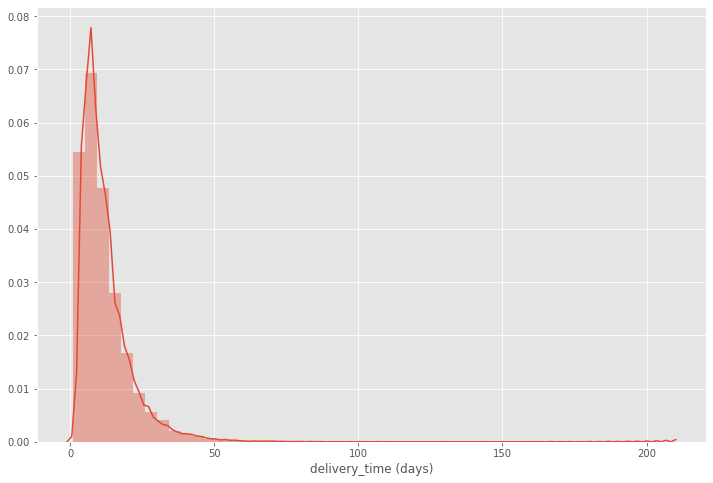

In [6]:
plt.figure(figsize= (12, 8))
sns.distplot(maindata['delivery_time (days)']);

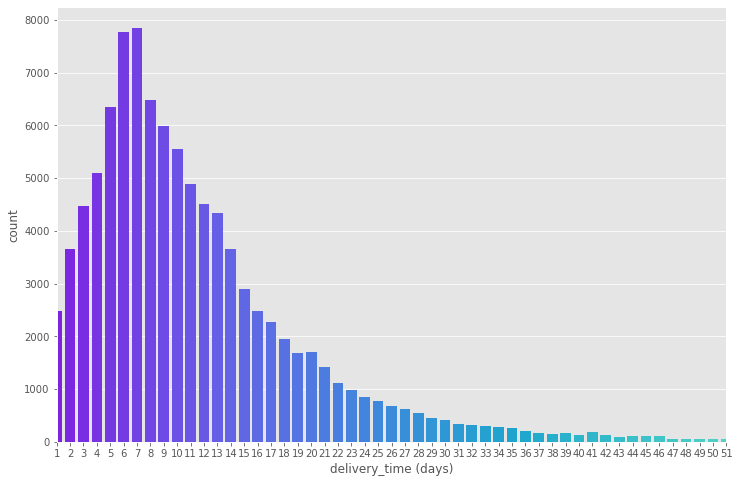

In [7]:
plt.figure(figsize= (12, 8))
sns.countplot(x='delivery_time (days)', data=maindata, palette= 'rainbow')
plt.xlim([0,50]);

Dari data lama waktu pengiriman ``[delivery_time (days)]`` dapat dilihat sebaran datanya skewness positif (cenderung kekiri), dan dapat diambil kesimpulan berdasarkan visualisasi tersebut:
- Data tidak terdistribusi normal.
- Lama waktu pengiriman paling banyak adalah 7 hari, diikuti oleh 6 hari, dengan jumlah pengiriman lebih dari 7000 kali.
- Memiliki rata-rata lama waktu pengiriman 11,5 hari, dan mean 9 hari.

<AxesSubplot:ylabel='delivery_time (days)'>

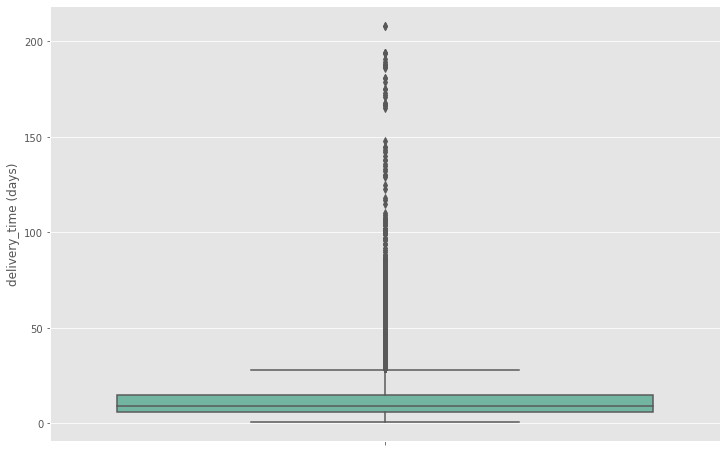

In [8]:
plt.figure(figsize= (12, 8))
sns.boxplot(maindata['delivery_time (days)'],  orient= 'v', palette= 'Set2')

In [9]:
find_outlier(maindata['delivery_time (days)'])

(-7.5, 28.5, array([40, 37, 46, ..., 38, 35, 32]))

In [10]:
len(find_outlier(maindata['delivery_time (days)'])[2])

4762

Berdasarkan pengecekan outlier pada data diatas dapat dilihat:
- bottom threshold bernilai: -7.5
- top threshold bernilai: 28.5
- jumlah outlier: 4762
- seluruh outlier berada pada area top threhold dengan nilai diatas 28.5

### Feature Selection

In [11]:
find_corr = maindata[maindata.describe().columns]
corr_matrix = find_corr.corr()
corr_matrix['delivery_time (days)'].sort_values(ascending=False)

delivery_time (days)                  1.00
shipping_time_(days)                  0.93
distance (Km)                         0.39
customer_zip_code                     0.27
customer_lat                          0.26
freight_value                         0.21
total_freight_value                   0.15
customer_lng                          0.11
product_weight_g                      0.08
volume_cm3                            0.07
total_payment                         0.07
product_length_cm                     0.06
product_height_cm                     0.06
price                                 0.06
total_volume_cm3                      0.06
total_price                           0.05
seller_lat                            0.05
seller_zip_code                       0.05
product_width_cm                      0.04
delivery_time/distance               -0.00
quantity                             -0.02
seller_lng                           -0.04
seller_delivery_performance (days)   -0.16
review_scor

Berdasarkan data diatas maka beberapa feature akan dipilih sesuai dengan domain knowledge dan type datanya yang mempengaruhi waktu pengiriman ``[delivery_time (days)]``, maka feature yang akan dibuang:
- customer_zip_code : karena sudah diwakili oleh jarak.
- customer_lat : karena sudah diwakili oleh jarak.
- customer_lng : karena sudah diwakili oleh jarak.
- seller_zip_code : karena sudah diwakili oleh jarak.
- seller_lat : karena sudah diwakili oleh jarak.
- seller_lng : karena sudah diwakili oleh jarak.
- delivery_time/distance : karena faktor tersebut merupakan dependent dari ``[delivery_time (days)]``.
- review_score : karena review score akan dimasukan setelah pengiriman dilakukan.
- delivery_performance (days): karena faktor tersebut merupakan dependent dari ``[delivery_time (days)]``.

In [12]:
find_corr = maindata[['distance (Km)', 'quantity', 'price', 'total_price',
                      'product_weight_g', 'product_length_cm', 'product_height_cm',
                      'product_width_cm', 'volume_cm3', 'total_volume_cm3',
                      'freight_value', 'total_freight_value', 'total_payment',
                      'seller_delivery_performance (days)', 'shipping_time_(days)',
                     'delivery_time (days)']]
corr_matrix = find_corr.corr()
corr_matrix['delivery_time (days)'].sort_values(ascending=False)

delivery_time (days)                  1.00
shipping_time_(days)                  0.93
distance (Km)                         0.39
freight_value                         0.21
total_freight_value                   0.15
product_weight_g                      0.08
volume_cm3                            0.07
total_payment                         0.07
product_length_cm                     0.06
product_height_cm                     0.06
price                                 0.06
total_volume_cm3                      0.06
total_price                           0.05
product_width_cm                      0.04
quantity                             -0.02
seller_delivery_performance (days)   -0.16
Name: delivery_time (days), dtype: float64

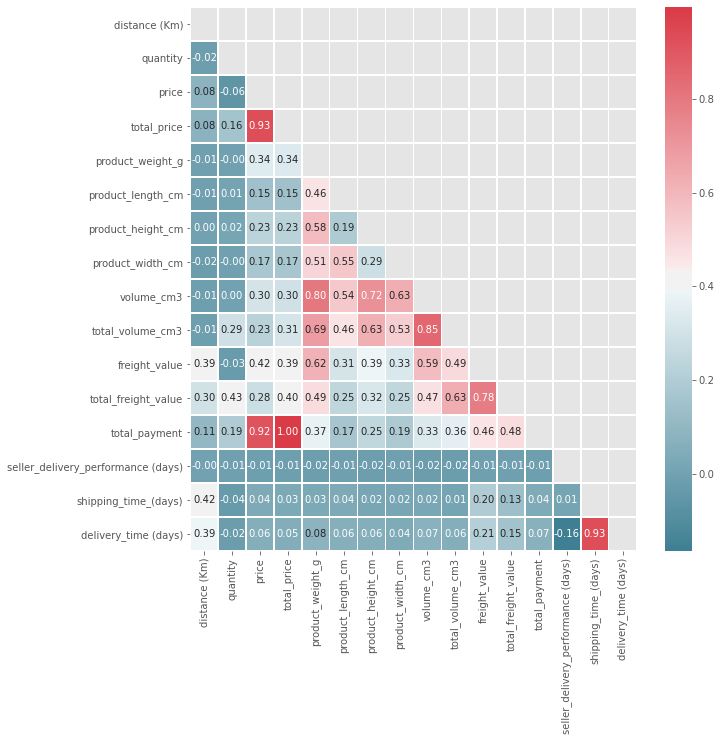

In [13]:
corr = maindata[['distance (Km)', 'quantity', 'price', 'total_price',
                      'product_weight_g', 'product_length_cm', 'product_height_cm',
                      'product_width_cm', 'volume_cm3', 'total_volume_cm3',
                      'freight_value', 'total_freight_value', 'total_payment',
                      'seller_delivery_performance (days)', 'shipping_time_(days)',
                      'delivery_time (days)']].corr()
fig, ax = plt.subplots(figsize = (10,10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, cmap=colormap, linewidths=0.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

Berdasarkan hasil observasi diatas, maka akan dubuat 3 data set dari **Normal Data**, yaitu:

**All Feature** : Seluruh feature dari feature selection digunakan untuk menjadi feature dependan (x).

In [14]:
nor_all = maindata[['distance (Km)', 'quantity', 'price', 'total_price','product_weight_g', 'product_length_cm',
                    'product_height_cm','product_width_cm', 'volume_cm3', 'total_volume_cm3','freight_value',
                    'total_freight_value', 'total_payment', 'seller_delivery_performance (days)', 'shipping_time_(days)',
                    'delivery_time (days)']]
display(nor_all.head(2), nor_all.shape)

,distance (Km),quantity,price,total_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,1,124.99,124.99,8683.00,54.00,64.00,31.00,107136.00,107136.00,21.88,21.88,146.87,-1,1,8
1,362.21,2,130.00,260.00,1600.00,20.00,60.00,20.00,24000.00,48000.00,15.00,30.00,290.00,1,5,6


(97893, 16)

**Correlation 1**: Menghilangkan feature yang memiliki nilai multikolinearitas dengan variable dependan lainya.

In [16]:
nor_corr1 = maindata[['distance (Km)', 'quantity', 'price', 'product_weight_g', 'volume_cm3', 'freight_value',
                      'total_payment', 'seller_delivery_performance (days)','shipping_time_(days)', 'delivery_time (days)']]
display(nor_corr1.head(2), nor_corr1.shape)

,distance (Km),quantity,price,product_weight_g,volume_cm3,freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,1,124.99,8683.00,107136.00,21.88,146.87,-1,1,8
1,362.21,2,130.00,1600.00,24000.00,15.00,290.00,1,5,6


(97893, 10)

**Correlation 2**: Menghilangkan feature yang memiliki nilai multikolinearitas dengan variable dependan lainya, dan hanya mengambil feature yang memiliki nilai korelasi > 0.1 atau < -0.1 terhadap target (y)

In [17]:
nor_corr2 = maindata[['distance (Km)', 'freight_value','seller_delivery_performance (days)','shipping_time_(days)',
                     'delivery_time (days)']]
display(nor_corr2.head(2), nor_corr2.shape)

,distance (Km),freight_value,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,21.88,-1,1,8
1,362.21,15.00,1,5,6


(97893, 5)

## Drop OL

Penulis juga ingin menguji dataset jika feature independen (y) di lakukan handling outlier, dengan melakukan drop outlier.

In [69]:
drop_ol = maindata.copy()

In [70]:
find_outlier(drop_ol['delivery_time (days)'])

(-7.5, 28.5, array([40, 37, 46, ..., 38, 35, 32]))

In [71]:
len(find_outlier(drop_ol['delivery_time (days)'])[2])

4762

In [72]:
drop_ol[(drop_ol['delivery_time (days)'] <= -7.5) | (drop_ol['delivery_time (days)'] >= 28.5)]

,customer_id,customer_zip_code,customer_city,customer_state,customer_lat,customer_lng,seller_id,seller_zip_code,seller_city,seller_state,seller_lat,seller_lng,distance (Km),order_id,order_status,review_score,quantity,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_estimated_delivery_date,actual_delivered_date,product_id,product_category_name_english,price,total_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),delivery_performance (days),shipping_time_(days),delivery_time (days),delivery_time/distance
18,9a493d06db3cccbef739e29498c2b176,68030,santarem,PA,-2.44,-54.72,41b39e28db005d9731d9d485a83b4c38,9220,santo andre,SP,-23.62,-46.54,2515.26,599647f3b1e2a0c0f0d2471bf9e9e353,delivered,1,1,2017-05-18 08:42:35,2017-05-19 02:15:18,2017-05-25 02:15:18,2017-05-22 07:52:02,2017-06-22 00:00:00,2017-06-28 15:38:47,6eb6618376baf873225738ce4fe760ac,bed_bath_table,34.90,34.90,300.00,36.00,6.00,26.00,5616.00,5616.00,26.89,26.89,61.79,2,-7,37,40,0.02
19,22a4b8a7912abc2b02051dca85e02564,68030,santarem,PA,-2.44,-54.72,de23c3b98a88888289c6f5cc1209054a,5530,sao paulo,SP,-23.58,-46.72,2503.81,b40d597f0eb58c117cb5d9e424f10426,delivered,2,1,2018-05-13 16:04:51,2018-05-13 16:15:16,2018-05-17 16:15:16,2018-05-17 11:57:00,2018-06-13 00:00:00,2018-06-19 20:16:35,94974b8c613bc6fae9700e6c01f626ae,stationery,165.00,165.00,225.00,20.00,6.00,13.00,1560.00,1560.00,39.20,39.20,204.20,0,-7,33,37,0.01
20,9a17a2d857d5a38a7a959f5cd1d1d015,68030,santarem,PA,-2.44,-54.72,440dd6ab244315c632130ecfb63827b1,15502,votuporanga,SP,-20.42,-49.99,2064.33,6a9c9e93c5bcd0e6b308ce42094a569f,delivered,1,1,2017-12-21 13:25:14,2017-12-22 13:14:30,2017-12-29 13:14:30,2017-12-27 18:04:45,2018-01-31 00:00:00,2018-02-06 23:29:00,c83cd797bc7742a94927dfce4efff001,sports_leisure,164.90,164.90,2100.00,80.00,8.00,15.00,9600.00,9600.00,29.55,29.55,194.45,1,-7,41,46,0.02
21,4854399f48d58dfce4a5b4994331b4a5,68030,santarem,PA,-2.44,-54.72,54a1852d1b8f10312c55e906355666ee,13456,santa barbara d'oeste,SP,-22.76,-47.38,2394.63,fb8f03cec06678a33b2782cb3f5a9942,delivered,5,1,2017-09-11 14:41:43,2017-09-11 14:50:32,2017-09-15 14:50:32,2017-09-12 18:26:51,2017-10-11 00:00:00,2017-10-11 18:44:05,d8de812ed5d981fc6a3984f4caa2aa05,sports_leisure,59.99,59.99,525.00,29.00,16.00,20.00,9280.00,9280.00,26.96,26.96,86.95,2,-1,29,30,0.01
53,10558ef4afea173bfb5e2cbe3d5b0bb5,78134,varzea grande,MT,-15.66,-56.13,7c67e1448b00f6e969d365cea6b010ab,8577,itaquaquecetuba,SP,-23.49,-46.37,1342.21,eaae5bd20fb15d85aa673d9b7c0e8ca5,delivered,2,1,2017-03-18 23:04:36,2017-03-18 23:04:36,2017-03-29 23:04:36,2017-03-28 06:29:47,2017-04-27 00:00:00,2017-05-30 09:19:58,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,126.99,126.99,8683.00,54.00,64.00,31.00,107136.00,107136.00,21.34,21.34,148.33,1,-34,63,72,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97833,1ecd973eedecc6e4983980892cd2b4ab,54705,sao lourenco da mata,PE,-8.01,-35.02,8d79c8a04e42d722a75097ce5cbcf2ef,61658,caucaia,CE,-3.77,-38.66,619.82,18e4264c34fe91aab3b39ea012932f3d,delivered,1,1,2017-02-22 14:17:03,2017-02-22 14:25:08,2017-02-28 14:17:03,2017-03-08 09:08:33,2017-03-23 00:00:00,2017-03-29 17:26:46,cd59f488cef311feb633141ad1e8563d,food,15.32,15.32,450.00,16.00,14.00,14.00,3136.00,3136.00,14.52,14.52,29.84,-8,-7,21,35,0.06
97843,343dde2a5e6b279975895db15e6e5483,74691,goiania,GO,-16.59,-49.28,e5a3438891c0bfdb9394643f95273d8e,13483,limeira,SP,-22.56,-47.45,691.36,a300439b291baea25827908be1277e29,delivered,3,1,2018-03-07 13:46:50,2018-03-07 14:09:10,2018-03-13 14:09:10,2018-03-10 00:22:40,2018-03-27 00:00:00,2018-04-11 00:10:48,d97cfa719a6198d4a66453e0c6ed596c,fashion_bags_accessories,34.30,34.30,250.00,16.00,2.00,20.00,640.00,640.00,18.23,18.23,52.53,3,-16,31

Ada 4762 oulier yang akan dibuang dengan bottom threshold -7.5 dan top trehshold 28.5

In [73]:
drop_ol = drop_ol[(drop_ol['delivery_time (days)'] > -7.5) & (drop_ol['delivery_time (days)'] < 28.5)]

In [80]:
drop_ol['delivery_time (days)'].describe()

count   93131.00
mean       10.14
std         6.06
min         1.00
25%         6.00
50%         9.00
75%        14.00
max        28.00
Name: delivery_time (days), dtype: float64

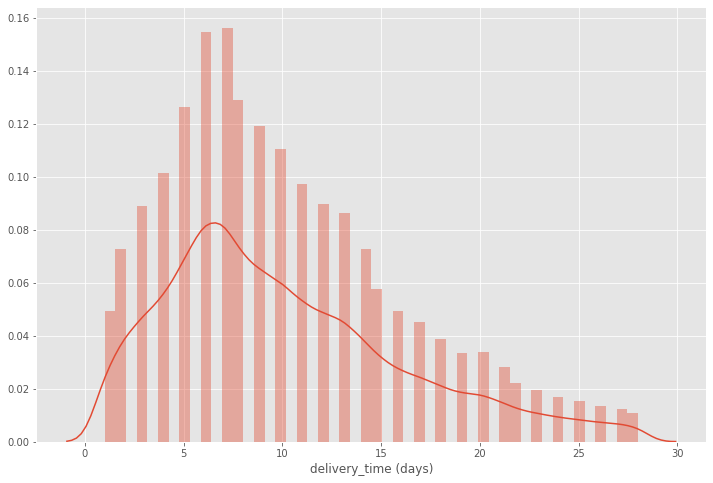

In [74]:
plt.figure(figsize= (12, 8))
sns.distplot(drop_ol['delivery_time (days)']);

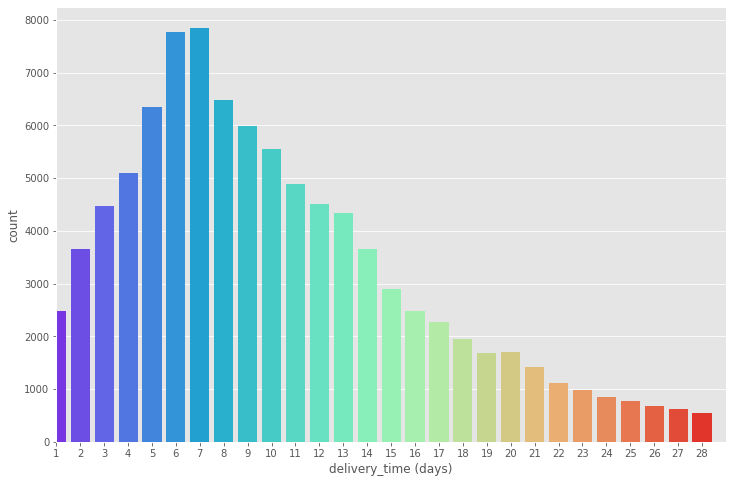

In [86]:
plt.figure(figsize= (12, 8))
sns.countplot(x='delivery_time (days)', data=drop_ol, palette= 'rainbow')
plt.xlim([0,28]);

Dari data lama waktu pengiriman ``[delivery_time (days)]`` yang sudah di drop outlier dapat dilihat sebaran datanya skewness positif (cenderung kekiri), dan dapat diambil kesimpulan berdasarkan visualisasi tersebut:
- Data tidak terdistribusi normal.
- Lama waktu pengiriman paling banyak adalah 7 hari, diikuti oleh 6 hari, dengan jumlah pengiriman lebih dari 7000 kali.
- Memiliki rata-rata lama waktu pengiriman berubah menjadi  10.14 hari, dan mean 9 hari.

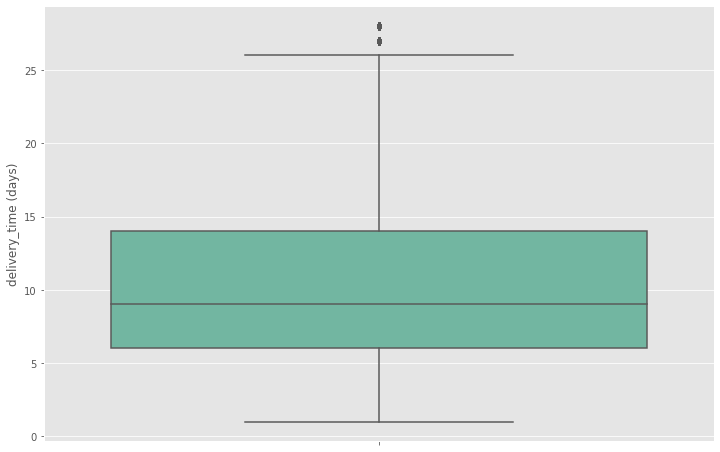

In [75]:
plt.figure(figsize= (12, 8))
sns.boxplot(drop_ol['delivery_time (days)'],  orient= 'v', palette= 'Set2');

In [76]:
find_outlier(drop_ol['delivery_time (days)'])

(-6.0, 26.0, array([27, 27, 28, ..., 27, 27, 28]))

In [77]:
len(find_outlier(drop_ol['delivery_time (days)'])[2])

1168

Berdasarkan pengecekan outlier pada data diatas dapat dilihat:
- bottom threshold bernilai: -6.0
- top threshold bernilai: 26.0
- jumlah outlier: 1168
- seluruh outlier berada pada area top threhold dengan nilai diatas 26.0

### Feature Selection

In [78]:
find_corr = drop_ol[['distance (Km)', 'quantity', 'price', 'total_price',
                     'product_weight_g', 'product_length_cm', 'product_height_cm',
                     'product_width_cm', 'volume_cm3', 'total_volume_cm3',
                     'freight_value', 'total_freight_value', 'total_payment',
                     'seller_delivery_performance (days)', 'shipping_time_(days)',
                    'delivery_time (days)']]
corr_matrix = find_corr.corr()
corr_matrix['delivery_time (days)'].sort_values(ascending=False)

delivery_time (days)                  1.00
shipping_time_(days)                  0.88
distance (Km)                         0.45
freight_value                         0.24
total_freight_value                   0.18
product_weight_g                      0.08
product_length_cm                     0.07
volume_cm3                            0.07
total_payment                         0.07
total_volume_cm3                      0.06
price                                 0.05
product_height_cm                     0.05
total_price                           0.05
product_width_cm                      0.05
quantity                             -0.02
seller_delivery_performance (days)   -0.12
Name: delivery_time (days), dtype: float64

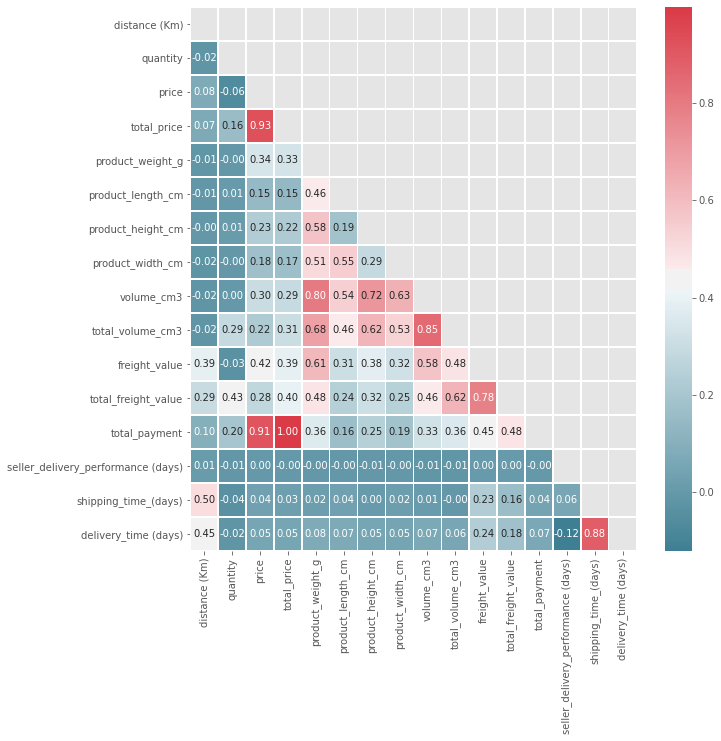

In [79]:
corr = drop_ol[['distance (Km)', 'quantity', 'price', 'total_price',
                 'product_weight_g', 'product_length_cm', 'product_height_cm',
                 'product_width_cm', 'volume_cm3', 'total_volume_cm3',
                 'freight_value', 'total_freight_value', 'total_payment',
                 'seller_delivery_performance (days)', 'shipping_time_(days)',
                 'delivery_time (days)']].corr()
fig, ax = plt.subplots(figsize = (10,10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, cmap=colormap, linewidths=0.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

Berdasarkan hasil observasi diatas, maka akan dubuat 3 data set dari **Drop Outlier**, yaitu:

**All Feature** : Seluruh feature dari feature selection digunakan untuk menjadi feature dependan (x).

In [88]:
drop_all = drop_ol[['distance (Km)', 'quantity', 'price', 'total_price','product_weight_g', 'product_length_cm',
                    'product_height_cm','product_width_cm', 'volume_cm3', 'total_volume_cm3','freight_value',
                    'total_freight_value', 'total_payment', 'seller_delivery_performance (days)', 'shipping_time_(days)',
                    'delivery_time (days)']]
display(drop_all.head(2), drop_all.shape)

,distance (Km),quantity,price,total_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,1,124.99,124.99,8683.00,54.00,64.00,31.00,107136.00,107136.00,21.88,21.88,146.87,-1,1,8
1,362.21,2,130.00,260.00,1600.00,20.00,60.00,20.00,24000.00,48000.00,15.00,30.00,290.00,1,5,6


(93131, 16)

**Correlation 1**: Menghilangkan feature yang memiliki nilai multikolinearitas dengan variable dependan lainya.

In [89]:
drop_corr1 = drop_ol[['distance (Km)', 'quantity', 'price', 'product_weight_g', 'volume_cm3', 'freight_value',
                      'total_payment', 'seller_delivery_performance (days)','shipping_time_(days)', 'delivery_time (days)']]
display(drop_corr1.head(2), drop_corr1.shape)

,distance (Km),quantity,price,product_weight_g,volume_cm3,freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,1,124.99,8683.00,107136.00,21.88,146.87,-1,1,8
1,362.21,2,130.00,1600.00,24000.00,15.00,290.00,1,5,6


(93131, 10)

**Correlation 2**: Menghilangkan feature yang memiliki nilai multikolinearitas dengan variable dependan lainya, dan hanya mengambil feature yang memiliki nilai korelasi > 0.1 atau < -0.1 terhadap target (y)

In [90]:
drop_corr2 = drop_ol[['distance (Km)', 'freight_value','seller_delivery_performance (days)','shipping_time_(days)',
                     'delivery_time (days)']]
display(drop_corr2.head(2), drop_corr2.shape)

,distance (Km),freight_value,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,21.88,-1,1,8
1,362.21,15.00,1,5,6


(93131, 5)

# Building Model

Model yang akan di bikin terdapat 6 dataset, yaitu:
- Normal Data:
    - All feature
    - Correlation 1
    - Corrlation 2
- Drop Outlier:
    - All feature
    - Correlation 1
    - Corrlation 2
Masing - masing dataset akan diuji menggunakan 7 model ML, yaitu:
- Normal Regression:
    - LinearRegression()
    - Lasso()
    - Ridge()
    - ElasticNet()
    - DecisionTreeRegressor()
    - RandomForestRegressor()
- Plynomoial Regression:
    - LinearRegression()
    - Lasso()
    - Ridge()
    - ElasticNet()
Hasil terbaik dari tiap dataset akan di ambil dan di bandingkan dengan dataset lainya, untuk dipilih ML yang akan digunakan dan di lakukan hyperparameter tunning untuk meningkatkan score ML tersebut.

# **Normal Data**

## All Feature From Feature Selection

### Spliting Data

In [25]:
x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

### Normal Regression

In [27]:
regressor = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = nor_all['delivery_time (days)'].mean()
for i in regressor:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 14325271.66
MAE	 = 6691862.27
R2 Score = -2319149250862.6157
RMSE (%) = 123489675.79%


Model	 = Lasso()
RMSE	 = 3.39
MAE	 = 2.09
R2 Score = 0.8702
RMSE (%) = 29.21%


Model	 = Ridge()
RMSE	 = 2.99
MAE	 = 1.83
R2 Score = 0.8987
RMSE (%) = 25.8%


Model	 = ElasticNet()
RMSE	 = 4.03
MAE	 = 2.67
R2 Score = 0.8162
RMSE (%) = 34.77%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.86
MAE	 = 1.74
R2 Score = 0.9073
RMSE (%) = 24.69%


Model	 = RandomForestRegressor()
RMSE	 = 2.07
MAE	 = 1.29
R2 Score = 0.9517
RMSE (%) = 17.81%




### Polynomial Regresion

In [28]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 136095626.01
MAE	 = 23953240.95
R2 Score = -209320277116771.06
RMSE (%) = 1173199722.16%


Model	 = Lasso()
RMSE	 = 3.18
MAE	 = 2.03
R2 Score = 0.8858
RMSE (%) = 27.41%


Model	 = Ridge()
RMSE	 = 2.69
MAE	 = 1.65
R2 Score = 0.918
RMSE (%) = 23.21%


Model	 = ElasticNet()
RMSE	 = 4.08
MAE	 = 2.84
R2 Score = 0.8123
RMSE (%) = 35.13%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.07** hari
- RMSE (%) : **17.81%**
- R2 Score : **0.9517**

## Choosing Best Model

In [29]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [30]:
mean_delivery_time = nor_all['delivery_time (days)'].mean()
rmse_nor_all = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_nor_all = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_nor_all = round( r2_score(y_test,y_pred), 4)

## Feature Based on Corr 1

### Spliting Data

In [31]:
x = nor_corr1.drop(columns= 'delivery_time (days)').values

y = nor_corr1['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

### Normal Regresion

In [33]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = nor_corr1['delivery_time (days)'].mean()
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.99
MAE	 = 1.82
R2 Score = 0.8986
RMSE (%) = 25.82%


Model	 = Lasso()
RMSE	 = 3.39
MAE	 = 2.09
R2 Score = 0.8702
RMSE (%) = 29.21%


Model	 = Ridge()
RMSE	 = 2.99
MAE	 = 1.82
R2 Score = 0.8986
RMSE (%) = 25.82%


Model	 = ElasticNet()
RMSE	 = 4.03
MAE	 = 2.67
R2 Score = 0.8161
RMSE (%) = 34.77%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.87
MAE	 = 1.73
R2 Score = 0.9069
RMSE (%) = 24.75%


Model	 = RandomForestRegressor()
RMSE	 = 2.11
MAE	 = 1.31
R2 Score = 0.9495
RMSE (%) = 18.23%




### Polynomial Regresion

In [34]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.73
MAE	 = 1.66
R2 Score = 0.9155
RMSE (%) = 23.57%


Model	 = Lasso()
RMSE	 = 3.18
MAE	 = 2.03
R2 Score = 0.8858
RMSE (%) = 27.4%


Model	 = Ridge()
RMSE	 = 2.73
MAE	 = 1.66
R2 Score = 0.9155
RMSE (%) = 23.57%


Model	 = ElasticNet()
RMSE	 = 4.08
MAE	 = 2.84
R2 Score = 0.8117
RMSE (%) = 35.19%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.11** hari
- RMSE (%) : **18.23%**
- R2 Score : **0.9495**

## Choosing Best Model

In [35]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [36]:
mean_delivery_time = nor_corr1['delivery_time (days)'].mean()
rmse_nor_corr1 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_nor_corr1 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_nor_corr1 = round( r2_score(y_test,y_pred), 4)

## Feature Based on Corr 2

### Spliting Data

In [37]:
x = nor_corr2.drop(columns= 'delivery_time (days)').values

y = nor_corr2['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

### Normal Regresion

In [39]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = maindata['delivery_time (days)'].mean()
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 3.01
MAE	 = 1.84
R2 Score = 0.8974
RMSE (%) = 25.98%


Model	 = Lasso()
RMSE	 = 3.4
MAE	 = 2.1
R2 Score = 0.8694
RMSE (%) = 29.31%


Model	 = Ridge()
RMSE	 = 3.01
MAE	 = 1.84
R2 Score = 0.8974
RMSE (%) = 25.98%


Model	 = ElasticNet()
RMSE	 = 4.04
MAE	 = 2.67
R2 Score = 0.8153
RMSE (%) = 34.85%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.98
MAE	 = 1.79
R2 Score = 0.8994
RMSE (%) = 25.72%


Model	 = RandomForestRegressor()
RMSE	 = 2.25
MAE	 = 1.41
R2 Score = 0.9427
RMSE (%) = 19.41%




### Polynomial Regresion

In [40]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.68
MAE	 = 1.67
R2 Score = 0.9187
RMSE (%) = 23.13%


Model	 = Lasso()
RMSE	 = 3.16
MAE	 = 2.02
R2 Score = 0.8869
RMSE (%) = 27.27%


Model	 = Ridge()
RMSE	 = 2.68
MAE	 = 1.67
R2 Score = 0.9187
RMSE (%) = 23.13%


Model	 = ElasticNet()
RMSE	 = 4.0
MAE	 = 2.85
R2 Score = 0.8193
RMSE (%) = 34.47%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.25** hari
- RMSE (%) : **19.41%**
- R2 Score : **0.9427**

## Choosing Best Model

In [41]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [42]:
mean_delivery_time = nor_corr2['delivery_time (days)'].mean()
rmse_nor_corr2 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_nor_corr2 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_nor_corr2 = round( r2_score(y_test,y_pred), 4)

# **Drop Outlier Data**

## All Feature From Feature Selection

### Spliting Data

In [43]:
x = drop_all.drop(columns= 'delivery_time (days)').values

y = drop_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [44]:
len(['distance (Km)', 'quantity', 'price', 'total_price',
             'product_weight_g', 'product_length_cm', 'product_height_cm',
             'product_width_cm', 'volume_cm3', 'total_volume_cm3',
             'freight_value', 'total_freight_value', 'total_payment',
             'seller_delivery_performance (days)', 'shipping_time_(days)'])

15

### Normal Regresion

In [45]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = drop_ol['delivery_time (days)'].mean()
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 21356931.7
MAE	 = 11855733.69
R2 Score = -12388242674099.205
RMSE (%) = 210679824.32%


Model	 = Lasso()
RMSE	 = 3.34
MAE	 = 2.51
R2 Score = 0.6968
RMSE (%) = 32.96%


Model	 = Ridge()
RMSE	 = 2.65
MAE	 = 1.84
R2 Score = 0.8091
RMSE (%) = 26.16%


Model	 = ElasticNet()
RMSE	 = 4.04
MAE	 = 3.16
R2 Score = 0.5578
RMSE (%) = 39.81%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.69
MAE	 = 1.82
R2 Score = 0.803
RMSE (%) = 26.57%


Model	 = RandomForestRegressor()
RMSE	 = 2.02
MAE	 = 1.43
R2 Score = 0.889
RMSE (%) = 19.95%




### Polynomial Regresion

In [46]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 36296630535.82
MAE	 = 4383195657.5
R2 Score = -3.5781999749825098e+19
RMSE (%) = 358055541560.6%


Model	 = Lasso()
RMSE	 = 3.29
MAE	 = 2.48
R2 Score = 0.7061
RMSE (%) = 32.45%


Model	 = Ridge()
RMSE	 = 2.46
MAE	 = 1.69
R2 Score = 0.8363
RMSE (%) = 24.22%


Model	 = ElasticNet()
RMSE	 = 3.83
MAE	 = 3.03
R2 Score = 0.6018
RMSE (%) = 37.77%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.02** hari
- RMSE (%) : **19.95%**
- R2 Score : **0.889**

## Choosing Best Model

In [47]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [48]:
mean_delivery_time = drop_all['delivery_time (days)'].mean()
rmse_drop_all = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_drop_all = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_drop_all = round( r2_score(y_test,y_pred), 4)

## Feature Based on Corr 1

### Spliting Data

In [49]:
x = drop_corr1.drop(columns= 'delivery_time (days)').values

y = drop_corr1['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [50]:
len(['distance (Km)', 'quantity', 'price',
             'product_weight_g', 'volume_cm3', 'freight_value',
             'total_payment', 'seller_delivery_performance (days)',
             'shipping_time_(days)'])

9

### Normal Regresion

In [51]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = drop_ol['delivery_time (days)'].mean()
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.66
MAE	 = 1.84
R2 Score = 0.8083
RMSE (%) = 26.21%


Model	 = Lasso()
RMSE	 = 3.34
MAE	 = 2.51
R2 Score = 0.6968
RMSE (%) = 32.96%


Model	 = Ridge()
RMSE	 = 2.66
MAE	 = 1.84
R2 Score = 0.8083
RMSE (%) = 26.21%


Model	 = ElasticNet()
RMSE	 = 4.04
MAE	 = 3.16
R2 Score = 0.5577
RMSE (%) = 39.81%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.74
MAE	 = 1.85
R2 Score = 0.7961
RMSE (%) = 27.03%


Model	 = RandomForestRegressor()
RMSE	 = 2.08
MAE	 = 1.46
R2 Score = 0.8829
RMSE (%) = 20.49%




### Polynomial Regresion

In [52]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.49
MAE	 = 1.7
R2 Score = 0.8313
RMSE (%) = 24.58%


Model	 = Lasso()
RMSE	 = 3.29
MAE	 = 2.48
R2 Score = 0.7059
RMSE (%) = 32.46%


Model	 = Ridge()
RMSE	 = 2.49
MAE	 = 1.7
R2 Score = 0.8313
RMSE (%) = 24.58%


Model	 = ElasticNet()
RMSE	 = 3.83
MAE	 = 3.03
R2 Score = 0.6015
RMSE (%) = 37.79%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.08** hari
- RMSE (%) : **0.49%**
- R2 Score : **0.8829**

## Choosing Best Model

In [53]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [54]:
mean_delivery_time = drop_corr1['delivery_time (days)'].mean()
rmse_drop_corr1 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_drop_corr1 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_drop_corr1 = round( r2_score(y_test,y_pred), 4)

## Feature Based on Corr 2

### Spliting Data

In [55]:
x = drop_corr2.drop(columns= 'delivery_time (days)').values

y = drop_corr2['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [56]:
len(['distance (Km)', 'freight_value','seller_delivery_performance (days)',
             'shipping_time_(days)'])

4

### Normal Regresion

In [57]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor()]
mean_delivery_time = drop_ol['delivery_time (days)'].mean()
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.68
MAE	 = 1.85
R2 Score = 0.8051
RMSE (%) = 26.43%


Model	 = Lasso()
RMSE	 = 3.34
MAE	 = 2.51
R2 Score = 0.6968
RMSE (%) = 32.96%


Model	 = Ridge()
RMSE	 = 2.68
MAE	 = 1.85
R2 Score = 0.8051
RMSE (%) = 26.43%


Model	 = ElasticNet()
RMSE	 = 4.04
MAE	 = 3.16
R2 Score = 0.5576
RMSE (%) = 39.81%


Model	 = DecisionTreeRegressor()
RMSE	 = 2.79
MAE	 = 1.9
R2 Score = 0.788
RMSE (%) = 27.56%


Model	 = RandomForestRegressor()
RMSE	 = 2.21
MAE	 = 1.55
R2 Score = 0.8674
RMSE (%) = 21.79%




### Polynomial Regresion

In [58]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
    print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 2.52
MAE	 = 1.72
R2 Score = 0.8272
RMSE (%) = 24.88%


Model	 = Lasso()
RMSE	 = 3.3
MAE	 = 2.48
R2 Score = 0.7039
RMSE (%) = 32.57%


Model	 = Ridge()
RMSE	 = 2.52
MAE	 = 1.72
R2 Score = 0.8272
RMSE (%) = 24.88%


Model	 = ElasticNet()
RMSE	 = 3.85
MAE	 = 3.05
R2 Score = 0.5966
RMSE (%) = 38.02%




Berdasarkan hasil score diatas dengan menggunakan data set yang sama, maka ML terbaik berdasarkan score RMSE terendah dan R2 Score tertinggi adalah:
- Model    : **RandomForestRegressor()**
- RMSE     : **2.21** hari
- RMSE (%) : **21.79%**
- R2 Score : **0.8674**

## Choosing Best Model

In [59]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [60]:
mean_delivery_time = drop_corr2['delivery_time (days)'].mean()
rmse_drop_corr2 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_drop_corr2 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_drop_corr2 = round( r2_score(y_test,y_pred), 4)

# **Comparing All Best Model**

In [62]:
comp_model = pd.DataFrame([[rmse_nor_all, rmse_nor_corr1, rmse_nor_corr2, rmse_drop_all, rmse_drop_corr1, rmse_drop_corr2],
                           [per_nor_all, per_nor_corr1, per_nor_corr2, per_drop_all, per_drop_corr1, per_drop_corr2],
                           [r2_nor_all, r2_nor_corr1, r2_nor_corr2, r2_drop_all, r2_drop_corr1, r2_drop_corr2]],
                     index= ['RMSE', 'Percentage RMSE', 'R2 Score'],
                     columns= ['RF_nor_all', 'RF_nor_corr1', 'RF_nor_corr2', 'RF_drop_all', 'RF_drop_corr1', 'RF_drop_corr2'])
comp_model.T

,RMSE,Percentage RMSE,R2 Score
RF_nor_all,2.06,17.8%,0.95
RF_nor_corr1,2.12,18.25%,0.95
RF_nor_corr2,2.25,19.43%,0.94
RF_drop_all,2.03,20.01%,0.89
RF_drop_corr1,2.08,20.49%,0.88
RF_drop_corr2,2.21,21.77%,0.87


Dari data diatas dapat disimpulkan bahwa dari 6 datset semua model terbaik berbeda menggunakan ML **RandomForest Regressor**,
dengan dangan nilai **RMSE** terendah:
- Dataset  : Drop outlier dengan Semua Feature
- RMSE     : 2.03
- RMSE (%) : 20.01%
- R2 Score : 0.89

Namun Nilai **R2 Score** tertinggi:
- Dataset  : Normal data dengan Semua Feature
- RMSE     : 2.06
- RMSE (%) : 17.8%
- R2 Score : 0.95

Dikarenakan selisih **RMSE** tersebut sangat rendah yaitu **0.03 (hari)/ +- 43 (menit)**, maka data set yang akan dipilih adalah dataset **Normal data dengan Semua Feature** supaya model lebih tahan terhadap outlier.

## Cross Validation

In [63]:
x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [64]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
regressor_train_pred = regressor.predict(x_train)
regressor_test_pred = regressor.predict(x_test)

In [65]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_NormalData_AllFeature'], 
              'CV error': [ (cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, regressor_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, regressor_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,regressor_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,regressor_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_NormalData_AllFeature,-2.21,0.30,0.80,2.06,0.99,0.95


In [66]:
cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5)

array([-2.7400453 , -1.92851292, -2.05929139, -2.35998996, -1.97824091])

In [67]:
cross_val_score(regressor, x, y, scoring='r2',cv=5)

array([0.92233174, 0.95634298, 0.94803154, 0.93501897, 0.96068475])

# **Hyperparameter Tuning**

In [68]:
x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [69]:
RFR = RandomForestRegressor()

In [70]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
RFR_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [71]:
RFR_param

{'n_estimators': [200, 1100, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [72]:
RSCV_RFR = RandomizedSearchCV(estimator = RFR, param_distributions = RFR_param, cv=5).fit(x_train, y_train)

In [73]:
print('best parameter RFR : ' ,RSCV_RFR.best_params_)

best parameter RFR :  {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


## Testing Hyperparameter Tuning Model

In [56]:
x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [76]:
regressor = RandomForestRegressor(n_estimators= 2000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto',
                                  max_depth= None, bootstrap= True)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
mean_delivery_time = nor_all['delivery_time (days)'].mean()

print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')

RMSE	 = 2.06
MAE	 = 1.27
R2 Score = 0.952
RMSE (%) = 17.76%


In [80]:
mean_delivery_time = nor_all['delivery_time (days)'].mean()
rmse_tune1 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_tune1 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_tune1 = round( r2_score(y_test,y_pred), 4)

## Tuning 2

In [57]:
regressor = RandomForestRegressor(n_estimators= 1100, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto',
                                  max_depth= None, bootstrap= True, random_state=42)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
mean_delivery_time = nor_all['delivery_time (days)'].mean()

print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')

RMSE	 = 2.05
MAE	 = 1.27
R2 Score = 0.9527
RMSE (%) = 17.64%


In [84]:
mean_delivery_time = nor_all['delivery_time (days)'].mean()
rmse_tune2 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_tune2 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_tune2 = round( r2_score(y_test,y_pred), 4)

## Tuning 3

In [85]:
regressor = RandomForestRegressor(n_estimators= 200, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto',
                                  max_depth= None, bootstrap= True, random_state=42)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
mean_delivery_time = nor_all['delivery_time (days)'].mean()

print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')

RMSE	 = 2.05
MAE	 = 1.27
R2 Score = 0.9525
RMSE (%) = 17.67%


In [86]:
mean_delivery_time = nor_all['delivery_time (days)'].mean()
rmse_tune3 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_tune3 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_tune3 = round( r2_score(y_test,y_pred), 4)

## Tuning 4

In [87]:
regressor = RandomForestRegressor(n_estimators= 2000, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto',
                                  max_depth= None, bootstrap= True, random_state=42)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
mean_delivery_time = nor_all['delivery_time (days)'].mean()

print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred), 4)}')
print(f'RMSE (%) = {round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2)}%')

RMSE	 = 2.05
MAE	 = 1.27
R2 Score = 0.9527
RMSE (%) = 17.64%


In [88]:
mean_delivery_time = nor_all['delivery_time (days)'].mean()
rmse_tune4 = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
per_tune4 = str(round((np.sqrt(mean_squared_error(y_test, y_pred))/mean_delivery_time * 100), 2))+'%'
r2_tune4 = round( r2_score(y_test,y_pred), 4)

## Comparing Model

In [89]:
comp_model_tuned = pd.DataFrame([[rmse_nor_all, rmse_tune1, rmse_tune2, rmse_tune3, rmse_tune4],
                           [per_nor_all, per_tune1, per_tune2, per_tune3, per_tune4],
                           [r2_nor_all, r2_tune1, r2_tune2, r2_tune3, r2_tune4]],
                     index= ['RMSE', 'Percentage RMSE', 'R2 Score'],
                     columns= ['RF_nor_all', 'tuned_1', 'tuned_2', 'tuned_3', 'tuned_4'])
comp_model_tuned.T

,RMSE,Percentage RMSE,R2 Score
RF_nor_all,2.06,17.8%,0.95
tuned_1,2.06,17.76%,0.95
tuned_2,2.05,17.64%,0.95
tuned_3,2.05,17.67%,0.95
tuned_4,2.05,17.64%,0.95


Berdasarkan data frame diatas maka dapat disimpulkan, ML terbaik setelah di tuning adalah ML **tuned_2**, dan **tuned_4** dengan nilai RMSE, Percentage RMSE, dan R2 Score yang sama, namun model ML yang akan digunakan adalah ML **tuned_2** dengan alasan hasil yang sama dengan komputasi lebih ringan dengan score:

- RMSE     : 2.05
- RMSE (%) : 17.64%
- R2 Score : 0.95



## Cross Validation

In [93]:
x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [94]:
regressor = RandomForestRegressor(n_estimators= 1100, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto',
                                  max_depth= None, bootstrap= True, random_state=42)
regressor.fit(x_train, y_train)
regressor_train_pred = regressor.predict(x_train)
regressor_test_pred = regressor.predict(x_test)

In [92]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_Tuned_2'], 
              'CV error': [ (cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, regressor_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, regressor_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,regressor_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,regressor_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_Tuned_2,-2.19,0.31,1.11,2.05,0.99,0.95


In [93]:
cross_val_score(regressor, x, y, scoring='neg_root_mean_squared_error',cv=5)

array([-2.72435719, -1.91633211, -2.03397236, -2.3337887 , -1.94555767])

In [94]:
cross_val_score(regressor, x, y, scoring='r2',cv=5)

array([0.92355675, 0.95695099, 0.94968681, 0.93620925, 0.96179728])

Berdasarkan hasil Cross Validation diatas dengan fold 5, makas score rata - rata dari 5 fold tersebut adalah 2.19 (hari), dengan hasil terbaik pada data training 1.11 hari, dan pada data test 2.05 hari.

In [32]:
df = pd.read_csv('Data For ML.csv')

In [33]:
df

,distance (Km),quantity,price,total_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.88,1,124.99,124.99,8683.00,54.00,64.00,31.00,107136.00,107136.00,21.88,21.88,146.87,-1,1,8
1,362.21,2,130.00,260.00,1600.00,20.00,60.00,20.00,24000.00,48000.00,15.00,30.00,290.00,1,5,6
2,204.21,1,79.90,79.90,1383.00,50.00,10.00,40.00,20000.00,20000.00,14.87,14.87,94.77,1,2,5
3,204.21,1,286.40,286.40,15150.00,63.00,30.00,43.00,81270.00,81270.00,37.51,37.51,323.91,2,6,7
4,247.40,1,139.90,139.90,1900.00,47.00,7.00,35.00,11515.00,11515.00,14.00,14.00,153.90,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97888,454.74,1,412.00,412.00,3000.00,30.00,30.00,20.00,18000.00,18000.00,20.50,20.50,432.50,5,4,5
97889,1640.01,1,410.00,410.00,2650.00,30.00,30.00,20.00,18000.00,18000.00,35.32,35.32,445.32,5,19,20
97890,1250.34,1,30.00,30.00,400.00,26.00,2.00,19.00,988.00,988.00,17.78,17.78,47.78,1,6,11
97891,553.30,1,84.90,84.90,150.00,16.00,5.00,12.00,960.00,960.00,18.69,18.69,103.59,1,4,6


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance (Km),97893.00,601.22,592.28,0.03,190.51,435.28,798.90,8680.64
quantity,97893.00,1.15,0.57,1.00,1.00,1.00,1.00,21.00
price,97893.00,123.96,187.81,0.85,40.00,78.00,139.00,6735.00
total_price,97893.00,136.37,208.45,0.85,45.87,84.99,149.90,13440.00
product_weight_g,97893.00,2092.46,3740.40,0.00,300.00,700.00,1800.00,40425.00
product_length_cm,97893.00,30.15,16.10,7.00,18.00,25.00,38.00,105.00
product_height_cm,97893.00,16.43,13.32,2.00,8.00,13.00,20.00,105.00
product_width_cm,97893.00,23.08,11.72,6.00,15.00,20.00,30.00,118.00
volume_cm3,97893.00,15184.51,23317.10,168.00,2816.00,6400.00,18375.00,296208.00
total_volume_cm3,97893.00,17520.16,31567.08,168.00,2964.00,7392.00,19872.00,1512000.00


In [3]:
nor_all.describe().T

,count,mean,std,min,25%,50%,75%,max
distance (Km),97893.0,601.216298,592.279050,0.025,190.511882,435.276707,798.895257,8.680636e+03
quantity,97893.0,1.151574,0.565464,1.000,1.000000,1.000000,1.000000,2.100000e+01
price,97893.0,123.956353,187.806822,0.850,40.000000,78.000000,139.000000,6.735000e+03
total_price,97893.0,136.372691,208.451801,0.850,45.870000,84.990000,149.900000,1.344000e+04
product_weight_g,97893.0,2092.459185,3740.404403,0.000,300.000000,700.000000,1800.000000,4.042500e+04
product_length_cm,97893.0,30.145067,16.103293,7.000,18.000000,25.000000,38.000000,1.050000e+02
product_height_cm,97893.0,16.431788,13.321028,2.000,8.000000,13.000000,20.000000,1.050000e+02
product_width_cm,97893.0,23.078157,11.720061,6.000,15.000000,20.000000,30.000000,1.180000e+02
volume_cm3,97893.0,15184.505368,23317.100954,168.000,2816.000000,6400.000000,18375.000000,2.962080e+05
total_volume_cm3,97893.0,17520.161074,31567.081899,168.000,2964.000000,7392.000000,19872.000000,1.512000e+06


In [2]:
nor_all = pd.read_csv('Data For ML.csv')
nor_all

,distance (Km),quantity,price,total_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3,total_volume_cm3,freight_value,total_freight_value,total_payment,seller_delivery_performance (days),shipping_time_(days),delivery_time (days)
0,348.880143,1,124.99,124.99,8683.0,54.0,64.0,31.0,107136.0,107136.0,21.88,21.88,146.87,-1,1,8
1,362.214896,2,130.00,260.00,1600.0,20.0,60.0,20.0,24000.0,48000.0,15.00,30.00,290.00,1,5,6
2,204.214075,1,79.90,79.90,1383.0,50.0,10.0,40.0,20000.0,20000.0,14.87,14.87,94.77,1,2,5
3,204.214075,1,286.40,286.40,15150.0,63.0,30.0,43.0,81270.0,81270.0,37.51,37.51,323.91,2,6,7
4,247.396090,1,139.90,139.90,1900.0,47.0,7.0,35.0,11515.0,11515.0,14.00,14.00,153.90,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97888,454.737271,1,412.00,412.00,3000.0,30.0,30.0,20.0,18000.0,18000.0,20.50,20.50,432.50,5,4,5
97889,1640.005410,1,410.00,410.00,2650.0,30.0,30.0,20.0,18000.0,18000.0,35.32,35.32,445.32,5,19,20
97890,1250.339041,1,30.00,30.00,400.0,26.0,2.0,19.0,988.0,988.0,17.78,17.78,47.78,1,6,11
97891,553.302197,1,84.90,84.90,150.0,16.0,5.0,12.0,960.0,960.0,18.69,18.69,103.59,1,4,6


In [38]:
df.info().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97893 entries, 0 to 97892
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   distance (Km)                       97893 non-null  float64
 1   quantity                            97893 non-null  int64  
 2   price                               97893 non-null  float64
 3   total_price                         97893 non-null  float64
 4   product_weight_g                    97893 non-null  float64
 5   product_length_cm                   97893 non-null  float64
 6   product_height_cm                   97893 non-null  float64
 7   product_width_cm                    97893 non-null  float64
 8   volume_cm3                          97893 non-null  float64
 9   total_volume_cm3                    97893 non-null  float64
 10  freight_value                       97893 non-null  float64
 11  total_freight_value                 97893

AttributeError: 'NoneType' object has no attribute 'T'

## Saving Model

In [16]:
nor_all = pd.read_csv('Data For ML.csv')

x = nor_all.drop(columns= 'delivery_time (days)').values

y = nor_all['delivery_time (days)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# x_train = RobustScaler().fit_transform(x_train)
# x_test = RobustScaler().fit_transform(x_test)

regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
joblib.dump(regressor, 'model_regressor')

['model_regressor']

In [31]:
nor_all.to_csv('Data For ML.csv', index= False)

In [19]:
nor_all[:100].to_html('Data.html')

# **Model Visualisation**

In [127]:
result_df = pd.DataFrame({'Actual Delivery (Days)' : np.array(y_test).flatten(),
                        'Predicted Delivery (Days)' : np.array(regressor_test_pred).flatten()
                        }).head(50)

result_df.head(10)

,Actual Delivery (Days),Predicted Delivery (Days)
0,26,17.31
1,7,4.91
2,12,11.62
3,108,105.98
4,13,12.45
5,1,1.53
6,6,4.29
7,6,5.22
8,10,9.64
9,6,6.58


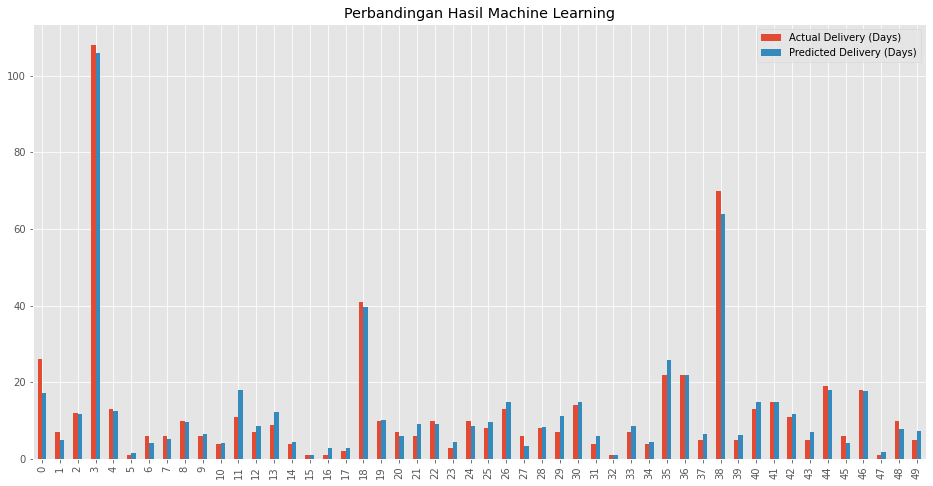

In [128]:
result_df.plot(kind='bar', figsize=(16,8))
plt.title('Difference between Actual Delivery (Days) vs Predicted Delivery (Days)')
plt.title('Perbandingan Hasil Machine Learning')
plt.savefig('Perbandingan Hasil Machine Learning.jpg', pil_kwargs={'quality': 95, 'optimize':True, 'bbox_inches' : 'tight'});
plt.show()

In [103]:
result_comp = pd.DataFrame({'Actual Delivery (Days)' : np.array(y_test).flatten(),
                            'Predicted Delivery (Days)' : np.array(regressor_test_pred).flatten()})
result_comp['error_days'] = result_comp['Predicted Delivery (Days)'] - result_comp['Actual Delivery (Days)']
display(result_comp.head(10), result_comp.shape)

,Actual Delivery (Days),Predicted Delivery (Days),error_days
0,26,17.31,-8.69
1,7,4.91,-2.09
2,12,11.62,-0.38
3,108,105.98,-2.02
4,13,12.45,-0.55
5,1,1.53,0.53
6,6,4.29,-1.71
7,6,5.22,-0.78
8,10,9.64,-0.36
9,6,6.58,0.58


(19579, 3)

In [105]:
maindata['delivery_performance (days)'].mean()

10.98166365317234

In [104]:
result_comp['error_days'].describe()

count   19579.00
mean        0.03
std         2.05
min       -37.67
25%        -0.65
50%         0.23
75%         1.02
max        11.86
Name: error_days, dtype: float64

In [108]:
display(result_comp[result_comp['error_days'] < -10.98166365317234].head(2), result_comp[result_comp['error_days'] < -10.98166365317234].shape)

,Actual Delivery (Days),Predicted Delivery (Days),error_days
74,49,28.69,-20.31
194,56,18.33,-37.67


(76, 3)

In [125]:
print(f"error bellow mean (%): {round((result_comp[result_comp['error_days'] < -10.98166365317234].shape[0] / result_comp.shape[0])*100,2)}%")
print(f"error above mean (%): {round((result_comp[result_comp['error_days'] > 10.98166365317234].shape[0] / result_comp.shape[0])*100,2)}%")
print(f"predicted after actual (%): {round((result_comp[result_comp['error_days'] > 0].shape[0] / result_comp.shape[0])*100,2)}%")
print(f"predicted same with actual (%): {round((result_comp[result_comp['error_days'] == 0].shape[0] / result_comp.shape[0])*100,2)}%")
print(f"error bellow 5 (days) (%): {round((result_comp[result_comp['error_days'] < -5].shape[0] / result_comp.shape[0])*100,2)}%")

error bellow mean (%): 0.39%
error above mean (%): 0.01%
predicted after actual (%): 56.73%
predicted same with actual (%): 0.0%
error bellow 5 (days) (%): 1.95%


# **Conclusion**

Berdasarkan pengujian model ML yang dilakukan diatas maka dapat disimpulkan:
- Dataset yang digunakan adalah dataset normal dengan menggunakan seluruh feature berdasarkan feature selection.
- Model ML yang digunakan setelah dilakukan hyperparameter tunning adalah:
    - RandomForestRegressor(n_estimators= 1100, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto', max_depth= None, bootstrap= True, random_state=42)
- Score yang didapat berdasarkan pengujian diatas adalah:
    - RMSE     : 2.05
    - RMSE (%) : 17.64%
    - CV Error : -2.19
    - R2 Score : 0.95
- RMSE 2.05 hari dan 2.19 hari terlihat besar jika dalam keterlambatan pengiriman, namun begitu jika dilihat dari hasil EDA sebelum nya diman rata - rata dari ``[delivery_performance (days)]`` pada angka 10.98 hari, maka angka error tersebut masih terhitung aman dan kecil.
- Bedasarkan observasi dari selisih hari actual dan predicted ``[error_days]`` pada data test, maka dapat dimaknai:
    - ``[hasil (-) tidak baik karena barang akan sampai setelah tanggal prediksi ML]``
    - ``[hasil (+) baik karena barang akan sampai sebelum tanggal prediksi ML]``
    - error bellow mean (%): 0.39%:
        - Hanya 0.39% data yang selisih antara predicted dan actualnya dibawah nilai rata - rata dari data set utama yaitu 10.98.
    - error above mean (%): 0.01%:
        - Hanya 0.01% data yang selisih antara predicted dan actualnya diatas nilai rata - rata dari data set utama yaitu 10.98.
    - predicted after actual (%): 56.73%:
        - Sebanyak 56.73% data yang memiliki hasil ``[error_days]`` (+) yang artinya barang akan sampai lebih dulu dari tanggal prediksi ML.
    - predicted same with actual (%): 0.0%:
        - Tidak ada data yang sama tanggal actual dan prediksi dengan ML.
    - error bellow 5 (days) (%): 1.95%:
        - Hanya 1.95% data yang memiliki nilai ``[error_days]`` di bawah 5 hari, artinya ML ini dapat digunakan sebagai ML baru untuk perusahaan untuk merubah dari rata - rata estimasi pengiriman 10.98 hari, menjadi 5 hari dengan persentase error 1.95%, berdasarkan hasil data test yang diuji.